Some important modules to import.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import astropy.units as u
from astropy.io import fits
from spectral_cube import SpectralCube
import astropy.constants as const
from helpers import get_pixel, get_uJy_cube
from data_reduction_functions import data_reduce

In [10]:
def generate_slices(fits_file, lambda_obs, v_centers, v_width=40*u.km/u.s, fit_width=0.005 * u.um, lambda_0=None):
    """
    Given a cube and velocity bin edges, return a list of 2D slices collapsed over each velocity bin.
    """
    cube = SpectralCube.read(fits_file, hdu=1)
    slices = []
    delta = v_width / 2
    
    for i in range(len(v_centers)):
        v_lo = v_centers[i] - delta
        v_hi = v_centers[i] + delta

        lambda_lo = lambda_obs * (1 + v_lo / const.c)
        lambda_hi = lambda_obs * (1 + v_hi / const.c)
        center_lambda = (lambda_lo + lambda_hi) / 2
        width = lambda_hi - lambda_lo

        slice_2d = data_reduce(fits_file, center_lambda, width, fit_width, lambda_0)
        slices.append(slice_2d)

        # Get the 2D WCS (drops spectral axis)
        wcs2d = cube.wcs.sub(['longitude', 'latitude'])

        # Create a FITS header from WCS
        header = wcs2d.to_header()
        
        # Create HDU and save
        hdu = fits.PrimaryHDU(data=slice_2d.value, header=header)
        name = f"../fits/channel_map5{i+1}.fits" # remember to change this number to match fits file
        hdu.writeto(name, overwrite=True)
        print(f"{i+1}/{len(v_centers)} Reduced slice written to file as {name}")

In [11]:
def plot_channel_maps(slices, v_centers, line):
    """
    Plot the 2D channel slices with titles showing center velocities and a shared colorbar.
    """
    ra = 69.896675 * u.degree
    dec = 25.69561666667 * u.degree
    x1, y1 = get_pixel(get_uJy_cube('../fits/4s3d.fits'), ra, dec)
    x1 -= 2
    y1 -= 1 # THESE ARE NOT REAL
    
    if line == 1.644*u.um:
        fig = plt.figure(figsize=(12, 6.5))
        gs = GridSpec(2, 5, figure=fig, width_ratios=[1,1,1,1,0.1])
        axes = [fig.add_subplot(gs[i]) for i in range(4)] + [fig.add_subplot(gs[i]) for i in range(5,9)]
        contour_levels = [1.5, 2.5, 5, 15]  # in μJy
        
    elif line == 2.803*u.um:
        fig = plt.figure(figsize=(14, 3))
        gs = GridSpec(1, 6, figure=fig, width_ratios=[1,1,1,1,1,0.1])
        axes = [fig.add_subplot(gs[i]) for i in range(5)] 
        contour_levels = [3,5,10,30]

    else:
        print("Line not implemented")
        return

    for i, (slice_2d, v_center) in enumerate(zip(slices, v_centers)):
        im = axes[i].imshow(np.log10(slice_2d), origin='lower', cmap='inferno', vmin=0, vmax=2.5)
        axes[i].text(0.02, 0.95, f"{v_center:.0f}", color='white', fontsize=11, transform=axes[i].transAxes, ha='left', va='top')
        axes[i].plot(x1, y1, marker='*', color='gold')
        axes[i].set_facecolor('black')
        axes[i].contour(slice_2d, levels=contour_levels, colors='cyan', linewidths=0.6)

        # Labels
        if line == 1.644*u.um:
            if i in [0,4]:
                axes[i].set_ylabel('Y pixel', fontsize=13)
                # axes[i].set_yticks([0,10,20,30,40,50])
                
            else:
                axes[i].set_ylabel('')
                axes[i].set_yticklabels([])
                
            if i in [4,5,6,7,8]:
                axes[i].set_xlabel('X pixel', fontsize=13)
                axes[i].set_xticks([0,10,20,30,40,50])
                
            else:
                axes[i].set_xlabel('')
                axes[i].set_xticks([0,10,20,30,40,50])
                axes[i].set_xticklabels([])
            
        elif line == 2.803*u.um:
            if i == 0:
                axes[i].set_ylabel('Y pixel', fontsize=13)
            else:
                axes[i].set_ylabel('')
                axes[i].set_yticklabels([])
            
            axes[i].set_xlabel('X pixel', fontsize=13)
            axes[i].set_xticks([0,10,20,30,40,50])
        
    # colorbar
    if line == 1.644*u.um:
        cbar_ax = fig.add_subplot(gs[:, 4])
        fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.2)
    elif line == 2.803*u.um:
        cbar_ax = fig.add_subplot(gs[5])
        fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.2)
    fig.colorbar(im, cax=cbar_ax, label='$\log_{10} F_\lambda \, (\mu Jy)$')
    plt.show()

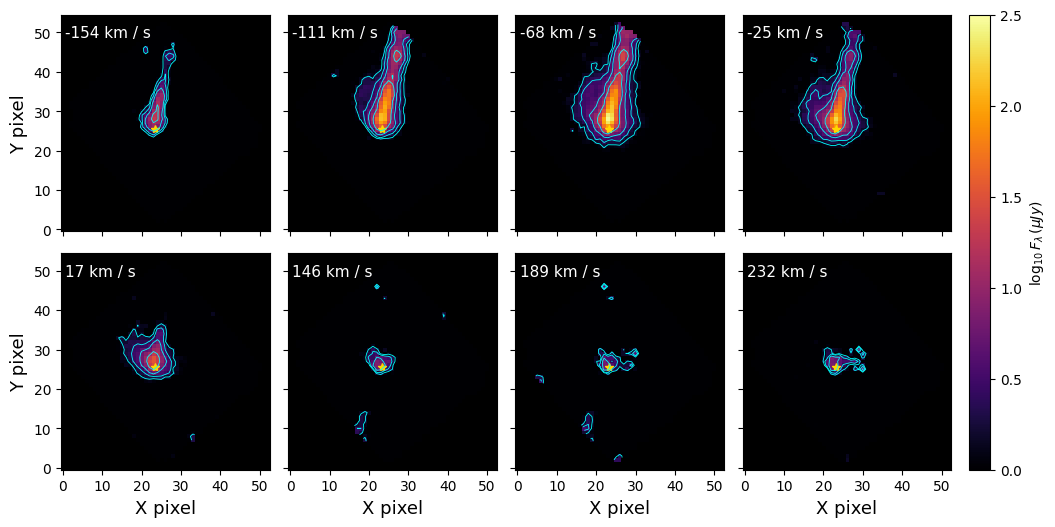

In [12]:
line = 1.644*u.um

if line == 1.644*u.um:
    v_centers = [-154, -111, -68, -25, 17, 146, 189, 232] * u.km/u.s # spaced out based on CDELT3 increment size
    slices = [fits.open(f"../fits/channel_map4{i+1}.fits")[0].data for i in range(8)]
elif line == 2.803*u.um:
    v_centers = [-110, -68, -25, 17, 59] * u.km/u.s
    slices = [fits.open(f"../fits/channel_map5{i+1}.fits")[0].data for i in range(5)]


# generate_slices('../fits/5s3d.fits', 2.8025*u.um, v_centers)
plot_channel_maps(slices, v_centers, line)